# PreTrain

In [1]:
from model.sswae_dev2_2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8
rm = [2,7]

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10 - len(rm) + 1),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [i for i in range(10) if i not in rm]
print("lab:", labeled_class, "rm:", rm)
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

lab: [0, 1, 3, 4, 5, 6, 8, 9] rm: [2, 7]


In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 20
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.249
[2] loss: 0.168
[3] loss: 0.050
[4] loss: 0.029
[5] loss: 0.019
[6] loss: 0.012
[7] loss: 0.011
[8] loss: 0.009
[9] loss: 0.008
[10] loss: 0.007
[11] loss: 0.005
[12] loss: 0.004
[13] loss: 0.005
[14] loss: 0.005
[15] loss: 0.004
[16] loss: 0.005
[17] loss: 0.005
[18] loss: 0.003
[19] loss: 0.001
[20] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

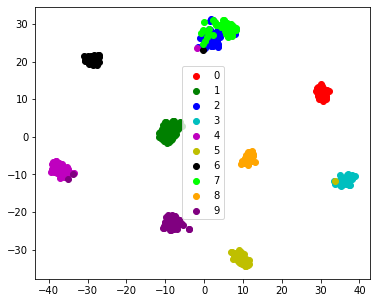

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

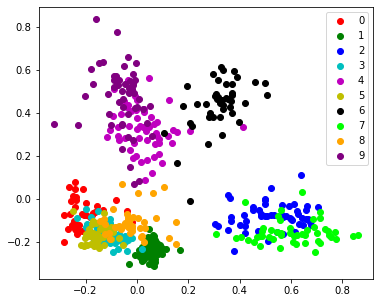

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, rm], portion = 1.0, class_no = True, unk=True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10 - len(rm) + 1, y_dim))
cs = np.zeros(10 - len(rm) + 1)
covs = np.zeros((10 - len(rm) + 1, y_dim, y_dim))

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10 - len(rm) + 1, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()
    
    for i in range(10 - len(rm)):
        cov = torch.cov(z[y==i,:].T, correction=0) * torch.sum(y==i)
        covs[i,:,:] += cov.detach().to('cpu').numpy()

In [12]:
w1 = torch.Tensor(ys.transpose()/cs)
w1

tensor([[-0.1924,  0.0579, -0.1141,  0.0322, -0.1406,  0.3075, -0.0437, -0.0514,
          0.5755],
        [-0.2556,  0.4481, -0.2901, -0.2522, -0.1973,  0.1538, -0.3279, -0.2045,
          0.1691],
        [-0.0786, -0.2397, -0.1490,  0.3393, -0.1648,  0.4226, -0.1273,  0.5184,
         -0.1267],
        [ 0.1850, -0.2776,  0.2243, -0.2089, -0.3113,  0.3402,  0.2330, -0.2639,
         -0.2497],
        [ 0.5830, -0.1777,  0.0067, -0.2249, -0.2608, -0.1785, -0.1302,  0.3038,
          0.4002],
        [ 0.0390,  0.5392, -0.2682,  0.3641, -0.2669, -0.2253,  0.5793, -0.0073,
         -0.2365],
        [-0.2425, -0.3717,  0.5043,  0.4574,  0.1930, -0.1104, -0.1740, -0.1988,
          0.2101],
        [-0.2678, -0.1684, -0.1772, -0.2200,  0.5249, -0.1057,  0.2807,  0.2255,
          0.1960]])

In [13]:
f1 = nn.Linear(10 - len(rm) + 1, y_dim, bias = False)
f1.weight.data = w1
torch.save(f1.state_dict(), f'./result/mu_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

In [14]:
w2 = torch.tensor((covs.T / (cs - 1)).T)
w2.shape

torch.Size([9, 8, 8])

In [15]:
for i in range(10 - len(rm) + 1):
    e, v = torch.symeig(w2[i,:,:], eigenvectors = True)
    w2[i,:,:] = v @ torch.diag(torch.sqrt(e)) @ v.T

In [16]:
f2 = nn.ConvTranspose2d(10 - len(rm) + 1, 1, y_dim, bias=False)
f2.weight.data = w2.view(10 - len(rm) + 1, 1, y_dim, y_dim)
torch.save(f2.state_dict(), f'./result/cov_{y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt')

# Train

In [17]:
from XAE.logging_daily import logging_daily

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_rm_0,1_unk.cfg')

['./config/sswae_dev2_rm_0,1_unk.cfg']

In [18]:
mm = cur_model(cfg, log, device = device)

mm.gm.mu.load_state_dict(torch.load(f'./result/mu_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))
mm.gm.cov.load_state_dict(torch.load(f'./result/cov_{mm.y_dim}_rm_{str(rm).replace(" ","")[1:-1]}_unk.pt'))

mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 4
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 0,1
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] unk : True
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_ba

[default |INFO|model.py:1823] [01/80]  loss: 2.467071e-01  D: 6.914314e-01  D2: 4.318349e-02  D3: 4.239157e-03
test loss: 1.874855e-01  D: 6.882732e-01  D2: 1.711557e-02  D3: 7.590175e-03


[default |INFO|model.py:1823] [02/80]  loss: 1.759029e-01  D: 6.942118e-01  D2: 1.118517e-02  D3: 8.187981e-03
test loss: 1.575592e-01  D: 6.887745e-01  D2: 6.734905e-03  D3: 7.867129e-03


[default |INFO|model.py:1823] [03/80]  loss: 1.460894e-01  D: 6.932683e-01  D2: 3.951896e-03  D3: 1.004355e-02
test loss: 1.345747e-01  D: 7.091544e-01  D2: 3.512087e-03  D3: 1.186624e-02


[default |INFO|model.py:1823] [04/80]  loss: 1.285067e-01  D: 6.962584e-01  D2: 5.219253e-04  D3: 1.114391e-02
test loss: 1.089927e-01  D: 6.997346e-01  D2: -7.205868e-04  D3: 1.259127e-02


[default |INFO|model.py:1823] [05/80]  loss: 1.118141e-01  D: 6.954982e-01  D2: -1.414425e-03  D3: 1.226496e-02
test loss: 1.010732e-01  D: 7.081768e-01  D2: 1.348209e-04  D3: 1.100613e-02


[default |INFO|model.py:1823] [06/80]  loss: 9.676576e-02  D: 6.931402e-01  D2: -2.558808e-03  D3: 1.352189e-02
test loss: 8.778170e-02  D: 6.632308e-01  D2: -2.509575e-03  D3: 1.409706e-02


[default |INFO|model.py:1823] [07/80]  loss: 8.628334e-02  D: 6.947610e-01  D2: -2.548707e-03  D3: 1.438788e-02
test loss: 8.341284e-02  D: 7.028001e-01  D2: -3.426085e-03  D3: 1.553696e-02


[default |INFO|model.py:1823] [08/80]  loss: 8.176426e-02  D: 6.940765e-01  D2: -2.698909e-03  D3: 1.463517e-02
test loss: 7.739344e-02  D: 6.850909e-01  D2: -3.069305e-03  D3: 1.570468e-02


[default |INFO|model.py:1823] [09/80]  loss: 7.663386e-02  D: 6.946909e-01  D2: -3.259967e-03  D3: 1.400586e-02
test loss: 7.276910e-02  D: 6.816122e-01  D2: -3.509512e-03  D3: 1.318339e-02


[default |INFO|model.py:1823] [10/80]  loss: 7.208315e-02  D: 6.937037e-01  D2: -3.355206e-03  D3: 1.379391e-02
test loss: 6.894422e-02  D: 6.890202e-01  D2: -3.888407e-03  D3: 1.447286e-02


[default |INFO|model.py:1823] [11/80]  loss: 6.858394e-02  D: 6.933101e-01  D2: -3.687441e-03  D3: 1.397928e-02
test loss: 6.684139e-02  D: 6.953263e-01  D2: -4.400215e-03  D3: 1.560943e-02


[default |INFO|model.py:1823] [12/80]  loss: 6.653477e-02  D: 6.938247e-01  D2: -4.010166e-03  D3: 1.373881e-02
test loss: 6.722658e-02  D: 6.955916e-01  D2: -4.093981e-03  D3: 1.435767e-02


[default |INFO|model.py:1823] [13/80]  loss: 6.507345e-02  D: 6.940819e-01  D2: -4.228641e-03  D3: 1.369229e-02
test loss: 6.305845e-02  D: 6.887117e-01  D2: -4.294453e-03  D3: 1.270926e-02


[default |INFO|model.py:1823] [14/80]  loss: 6.329738e-02  D: 6.947160e-01  D2: -4.335303e-03  D3: 1.353993e-02
test loss: 6.233714e-02  D: 6.794117e-01  D2: -5.101004e-03  D3: 1.161586e-02


[default |INFO|model.py:1823] [15/80]  loss: 6.263045e-02  D: 6.932389e-01  D2: -4.675935e-03  D3: 1.345020e-02
test loss: 6.287474e-02  D: 6.794305e-01  D2: -4.445324e-03  D3: 1.330061e-02


[default |INFO|model.py:1823] [16/80]  loss: 6.125847e-02  D: 6.939108e-01  D2: -4.693975e-03  D3: 1.325029e-02
test loss: 6.074714e-02  D: 7.026019e-01  D2: -5.120897e-03  D3: 1.304094e-02


[default |INFO|model.py:1823] [17/80]  loss: 5.957891e-02  D: 6.934839e-01  D2: -4.716028e-03  D3: 1.330069e-02
test loss: 5.919871e-02  D: 6.912112e-01  D2: -4.940987e-03  D3: 1.233880e-02


[default |INFO|model.py:1823] [18/80]  loss: 5.922013e-02  D: 6.935788e-01  D2: -4.824600e-03  D3: 1.337819e-02
test loss: 5.911480e-02  D: 6.992455e-01  D2: -4.615107e-03  D3: 1.275488e-02


[default |INFO|model.py:1823] [19/80]  loss: 5.850634e-02  D: 6.941905e-01  D2: -5.227559e-03  D3: 1.295877e-02
test loss: 5.907182e-02  D: 7.003123e-01  D2: -4.937153e-03  D3: 1.168272e-02


[default |INFO|model.py:1823] [20/80]  loss: 5.876792e-02  D: 6.940445e-01  D2: -5.120635e-03  D3: 1.267791e-02
test loss: 5.804201e-02  D: 6.909114e-01  D2: -5.253105e-03  D3: 1.231237e-02


[default |INFO|model.py:1823] [21/80]  loss: 5.821896e-02  D: 6.936294e-01  D2: -5.190830e-03  D3: 1.269442e-02
test loss: 6.170167e-02  D: 6.959347e-01  D2: -5.747471e-03  D3: 1.019220e-02


[default |INFO|model.py:1823] [22/80]  loss: 5.986545e-02  D: 6.936148e-01  D2: -5.225983e-03  D3: 1.230610e-02
test loss: 5.928727e-02  D: 7.080313e-01  D2: -5.515909e-03  D3: 1.415035e-02


[default |INFO|model.py:1823] [23/80]  loss: 5.673329e-02  D: 6.939019e-01  D2: -5.372276e-03  D3: 1.299463e-02
test loss: 5.796087e-02  D: 6.971406e-01  D2: -5.207138e-03  D3: 1.229620e-02


[default |INFO|model.py:1823] [24/80]  loss: 5.576106e-02  D: 6.935568e-01  D2: -5.419461e-03  D3: 1.289646e-02
test loss: 5.726750e-02  D: 6.880184e-01  D2: -5.736504e-03  D3: 1.065742e-02


[default |INFO|model.py:1823] [25/80]  loss: 5.578176e-02  D: 6.929647e-01  D2: -5.790660e-03  D3: 1.301234e-02
test loss: 5.508088e-02  D: 6.828743e-01  D2: -5.523100e-03  D3: 1.358088e-02


[default |INFO|model.py:1823] [26/80]  loss: 5.475203e-02  D: 6.935302e-01  D2: -5.810246e-03  D3: 1.306342e-02
test loss: 5.552564e-02  D: 6.941954e-01  D2: -6.265068e-03  D3: 1.371529e-02


[default |INFO|model.py:1823] [27/80]  loss: 5.575261e-02  D: 6.937891e-01  D2: -5.604644e-03  D3: 1.252712e-02
test loss: 5.552343e-02  D: 6.884414e-01  D2: -6.291189e-03  D3: 1.496462e-02


[default |INFO|model.py:1823] [28/80]  loss: 5.455667e-02  D: 6.929883e-01  D2: -5.948847e-03  D3: 1.282957e-02
test loss: 5.568901e-02  D: 7.019079e-01  D2: -6.441975e-03  D3: 1.111070e-02


[default |INFO|model.py:1823] [29/80]  loss: 5.809746e-02  D: 6.948610e-01  D2: -5.934431e-03  D3: 1.184393e-02
test loss: 5.956525e-02  D: 6.891197e-01  D2: -6.240664e-03  D3: 1.059437e-02


[default |INFO|model.py:1823] [30/80]  loss: 5.483868e-02  D: 6.938499e-01  D2: -5.937910e-03  D3: 1.265401e-02
test loss: 5.432317e-02  D: 6.905409e-01  D2: -6.299629e-03  D3: 1.265564e-02


[default |INFO|model.py:1823] [31/80]  loss: 5.387090e-02  D: 6.935358e-01  D2: -6.207873e-03  D3: 1.279840e-02
test loss: 5.333546e-02  D: 7.009871e-01  D2: -5.956602e-03  D3: 1.370092e-02


[default |INFO|model.py:1823] [32/80]  loss: 5.341993e-02  D: 6.935879e-01  D2: -6.246861e-03  D3: 1.283057e-02
test loss: 5.683068e-02  D: 6.854621e-01  D2: -6.258249e-03  D3: 1.178362e-02


[default |INFO|model.py:1823] [33/80]  loss: 5.383669e-02  D: 6.934258e-01  D2: -6.365565e-03  D3: 1.262323e-02
test loss: 5.489543e-02  D: 6.948117e-01  D2: -6.290369e-03  D3: 1.149618e-02


[default |INFO|model.py:1823] [34/80]  loss: 5.360329e-02  D: 6.934360e-01  D2: -6.567918e-03  D3: 1.252605e-02
test loss: 5.516553e-02  D: 6.811301e-01  D2: -6.914225e-03  D3: 1.232119e-02


[default |INFO|model.py:1823] [35/80]  loss: 5.389600e-02  D: 6.935904e-01  D2: -6.615505e-03  D3: 1.248319e-02
test loss: 5.407400e-02  D: 6.973636e-01  D2: -6.662207e-03  D3: 1.189267e-02


[default |INFO|model.py:1823] [36/80]  loss: 5.327257e-02  D: 6.934132e-01  D2: -6.720630e-03  D3: 1.238372e-02
test loss: 5.313100e-02  D: 6.996010e-01  D2: -7.132015e-03  D3: 1.193599e-02


[default |INFO|model.py:1823] [37/80]  loss: 5.319758e-02  D: 6.933687e-01  D2: -6.844516e-03  D3: 1.241794e-02
test loss: 5.494501e-02  D: 6.906632e-01  D2: -7.108345e-03  D3: 1.191051e-02


[default |INFO|model.py:1823] [38/80]  loss: 5.267324e-02  D: 6.933522e-01  D2: -6.865228e-03  D3: 1.241576e-02
test loss: 5.377091e-02  D: 6.902150e-01  D2: -7.322187e-03  D3: 1.274052e-02


[default |INFO|model.py:1823] [39/80]  loss: 5.316791e-02  D: 6.935646e-01  D2: -6.801613e-03  D3: 1.236372e-02
test loss: 5.399924e-02  D: 6.945178e-01  D2: -7.012300e-03  D3: 1.317673e-02


[default |INFO|model.py:1823] [40/80]  loss: 5.272780e-02  D: 6.935737e-01  D2: -6.958329e-03  D3: 1.240455e-02
test loss: 5.361810e-02  D: 7.092153e-01  D2: -6.783991e-03  D3: 1.144519e-02


[default |INFO|model.py:1823] [41/80]  loss: 5.276686e-02  D: 6.931905e-01  D2: -7.105376e-03  D3: 1.218407e-02
test loss: 5.281521e-02  D: 7.007119e-01  D2: -6.904182e-03  D3: 1.308660e-02


[default |INFO|model.py:1823] [42/80]  loss: 5.225060e-02  D: 6.935709e-01  D2: -7.106320e-03  D3: 1.226186e-02
test loss: 5.530677e-02  D: 6.958659e-01  D2: -7.360859e-03  D3: 1.292624e-02


[default |INFO|model.py:1823] [43/80]  loss: 5.256002e-02  D: 6.937877e-01  D2: -7.124276e-03  D3: 1.203090e-02
test loss: 5.426627e-02  D: 7.115050e-01  D2: -7.214556e-03  D3: 1.069181e-02


[default |INFO|model.py:1823] [44/80]  loss: 5.235519e-02  D: 6.929809e-01  D2: -7.114509e-03  D3: 1.220386e-02
test loss: 5.232766e-02  D: 7.033227e-01  D2: -6.800337e-03  D3: 1.161183e-02


[default |INFO|model.py:1823] [45/80]  loss: 5.240324e-02  D: 6.941120e-01  D2: -7.311559e-03  D3: 1.187227e-02
test loss: 5.357506e-02  D: 6.975688e-01  D2: -7.547112e-03  D3: 1.319479e-02


[default |INFO|model.py:1823] [46/80]  loss: 5.206669e-02  D: 6.930977e-01  D2: -7.465545e-03  D3: 1.220241e-02
test loss: 5.378360e-02  D: 6.939748e-01  D2: -7.543554e-03  D3: 1.288009e-02


[default |INFO|model.py:1823] [47/80]  loss: 5.172881e-02  D: 6.931855e-01  D2: -7.451960e-03  D3: 1.218566e-02
test loss: 5.353472e-02  D: 6.894863e-01  D2: -7.583542e-03  D3: 1.057020e-02


[default |INFO|model.py:1823] [48/80]  loss: 5.176133e-02  D: 6.930310e-01  D2: -7.572940e-03  D3: 1.204297e-02
test loss: 5.351408e-02  D: 6.863437e-01  D2: -7.496881e-03  D3: 1.258340e-02


[default |INFO|model.py:1823] [49/80]  loss: 5.133525e-02  D: 6.936224e-01  D2: -7.538182e-03  D3: 1.211227e-02
test loss: 5.314605e-02  D: 6.835566e-01  D2: -7.503376e-03  D3: 1.272607e-02


[default |INFO|model.py:1823] [50/80]  loss: 5.200296e-02  D: 6.932444e-01  D2: -7.624009e-03  D3: 1.200886e-02
test loss: 5.353503e-02  D: 7.046318e-01  D2: -7.669764e-03  D3: 1.052538e-02


[default |INFO|model.py:1823] [51/80]  loss: 5.220021e-02  D: 6.933879e-01  D2: -7.639677e-03  D3: 1.198459e-02
test loss: 5.448313e-02  D: 6.918778e-01  D2: -7.381153e-03  D3: 1.014178e-02


[default |INFO|model.py:1823] [52/80]  loss: 5.135883e-02  D: 6.936531e-01  D2: -7.715410e-03  D3: 1.191386e-02
test loss: 5.290699e-02  D: 6.921943e-01  D2: -8.019466e-03  D3: 1.257340e-02


[default |INFO|model.py:1823] [53/80]  loss: 5.048714e-02  D: 6.930416e-01  D2: -7.796089e-03  D3: 1.214280e-02
test loss: 5.264872e-02  D: 6.992111e-01  D2: -7.829685e-03  D3: 1.275135e-02


[default |INFO|model.py:1823] [54/80]  loss: 5.086300e-02  D: 6.935739e-01  D2: -7.766293e-03  D3: 1.208395e-02
test loss: 5.221147e-02  D: 6.895626e-01  D2: -8.190088e-03  D3: 1.179525e-02


[default |INFO|model.py:1823] [55/80]  loss: 5.143540e-02  D: 6.934901e-01  D2: -7.887657e-03  D3: 1.183849e-02
test loss: 5.306740e-02  D: 7.009118e-01  D2: -7.910280e-03  D3: 1.112502e-02


[default |INFO|model.py:1823] [56/80]  loss: 5.036079e-02  D: 6.930001e-01  D2: -7.910627e-03  D3: 1.201470e-02
test loss: 5.200025e-02  D: 6.875970e-01  D2: -7.924232e-03  D3: 1.205944e-02


[default |INFO|model.py:1823] [57/80]  loss: 5.013506e-02  D: 6.933285e-01  D2: -8.010403e-03  D3: 1.191634e-02
test loss: 5.410901e-02  D: 7.000544e-01  D2: -8.046427e-03  D3: 1.174578e-02


[default |INFO|model.py:1823] [58/80]  loss: 5.162963e-02  D: 6.934555e-01  D2: -7.967319e-03  D3: 1.169333e-02
test loss: 5.219720e-02  D: 6.997275e-01  D2: -7.858248e-03  D3: 1.057304e-02


[default |INFO|model.py:1823] [59/80]  loss: 5.087308e-02  D: 6.934711e-01  D2: -8.019075e-03  D3: 1.178370e-02
test loss: 5.496788e-02  D: 7.007054e-01  D2: -8.020515e-03  D3: 9.868863e-03


[default |INFO|model.py:1823] [60/80]  loss: 5.216837e-02  D: 6.930203e-01  D2: -8.022550e-03  D3: 1.148593e-02
test loss: 5.345993e-02  D: 6.918824e-01  D2: -7.988100e-03  D3: 1.490033e-02


[default |INFO|model.py:1823] [61/80]  loss: 5.025506e-02  D: 6.931321e-01  D2: -8.183179e-03  D3: 1.187304e-02
test loss: 5.142600e-02  D: 6.903816e-01  D2: -8.287067e-03  D3: 1.283904e-02


[default |INFO|model.py:1823] [62/80]  loss: 4.979636e-02  D: 6.936210e-01  D2: -8.197953e-03  D3: 1.193879e-02
test loss: 5.194287e-02  D: 6.936609e-01  D2: -7.849827e-03  D3: 1.244639e-02


[default |INFO|model.py:1823] [63/80]  loss: 5.014530e-02  D: 6.936779e-01  D2: -8.246959e-03  D3: 1.168735e-02
test loss: 5.191194e-02  D: 7.036595e-01  D2: -8.126936e-03  D3: 1.222679e-02


[default |INFO|model.py:1823] [64/80]  loss: 5.016108e-02  D: 6.935071e-01  D2: -8.233005e-03  D3: 1.175252e-02
test loss: 5.292783e-02  D: 6.952528e-01  D2: -7.950191e-03  D3: 1.153137e-02


[default |INFO|model.py:1823] [65/80]  loss: 5.034386e-02  D: 6.927791e-01  D2: -8.257648e-03  D3: 1.171077e-02
test loss: 5.196658e-02  D: 6.797809e-01  D2: -8.118420e-03  D3: 1.149030e-02


[default |INFO|model.py:1823] [66/80]  loss: 5.051055e-02  D: 6.930093e-01  D2: -8.281012e-03  D3: 1.148757e-02
test loss: 5.273672e-02  D: 6.945152e-01  D2: -8.622589e-03  D3: 1.010456e-02


[default |INFO|model.py:1823] [67/80]  loss: 5.032726e-02  D: 6.934093e-01  D2: -8.371868e-03  D3: 1.162062e-02
test loss: 5.186278e-02  D: 6.889654e-01  D2: -8.355179e-03  D3: 1.070635e-02


[default |INFO|model.py:1823] [68/80]  loss: 4.992934e-02  D: 6.929919e-01  D2: -8.417010e-03  D3: 1.177554e-02
test loss: 5.317165e-02  D: 6.918253e-01  D2: -8.423815e-03  D3: 9.849532e-03


[default |INFO|model.py:1823] [69/80]  loss: 4.993334e-02  D: 6.930608e-01  D2: -8.400682e-03  D3: 1.159353e-02
test loss: 5.353903e-02  D: 6.969090e-01  D2: -8.343706e-03  D3: 9.617687e-03


[default |INFO|model.py:1823] [70/80]  loss: 5.056316e-02  D: 6.935221e-01  D2: -8.439247e-03  D3: 1.141891e-02
test loss: 5.289233e-02  D: 7.053940e-01  D2: -8.116217e-03  D3: 1.294786e-02


[default |INFO|model.py:1823] [71/80]  loss: 5.024792e-02  D: 6.935789e-01  D2: -8.424956e-03  D3: 1.152898e-02
test loss: 5.257177e-02  D: 6.917278e-01  D2: -8.435450e-03  D3: 1.384112e-02


[default |INFO|model.py:1823] [72/80]  loss: 4.941783e-02  D: 6.935364e-01  D2: -8.469949e-03  D3: 1.171719e-02
test loss: 5.178170e-02  D: 6.955702e-01  D2: -8.338594e-03  D3: 1.279240e-02


[default |INFO|model.py:1823] [73/80]  loss: 4.890311e-02  D: 6.928654e-01  D2: -8.596786e-03  D3: 1.166875e-02
test loss: 5.200816e-02  D: 6.957458e-01  D2: -8.521309e-03  D3: 1.233172e-02


[default |INFO|model.py:1823] [74/80]  loss: 4.881559e-02  D: 6.931987e-01  D2: -8.530650e-03  D3: 1.168278e-02
test loss: 5.180851e-02  D: 6.873148e-01  D2: -8.608427e-03  D3: 1.149647e-02


[default |INFO|model.py:1823] [75/80]  loss: 4.881395e-02  D: 6.930328e-01  D2: -8.605291e-03  D3: 1.174111e-02
test loss: 5.217130e-02  D: 6.918435e-01  D2: -8.475494e-03  D3: 1.195650e-02


[default |INFO|model.py:1823] [76/80]  loss: 4.899958e-02  D: 6.934333e-01  D2: -8.572825e-03  D3: 1.170818e-02
test loss: 5.299085e-02  D: 6.999522e-01  D2: -8.470240e-03  D3: 1.219144e-02


[default |INFO|model.py:1823] [77/80]  loss: 4.934680e-02  D: 6.933461e-01  D2: -8.555951e-03  D3: 1.161367e-02
test loss: 5.206841e-02  D: 6.974788e-01  D2: -8.665562e-03  D3: 1.112437e-02


[default |INFO|model.py:1823] [78/80]  loss: 4.867409e-02  D: 6.929154e-01  D2: -8.619475e-03  D3: 1.164908e-02
test loss: 5.183645e-02  D: 7.030098e-01  D2: -8.815880e-03  D3: 1.169057e-02


[default |INFO|model.py:1823] [79/80]  loss: 4.898297e-02  D: 6.932050e-01  D2: -8.705713e-03  D3: 1.150490e-02
test loss: 5.185933e-02  D: 6.907230e-01  D2: -8.657589e-03  D3: 1.114751e-02


[default |INFO|model.py:1823] [80/80]  loss: 4.867919e-02  D: 6.933390e-01  D2: -8.700496e-03  D3: 1.159728e-02
test loss: 5.188541e-02  D: 6.969736e-01  D2: -8.557205e-03  D3: 1.121608e-02


[default |INFO|model.py:1938] Training Finished!
[default |INFO|model.py:1939] Elapsed time: 1671.153s


# Test

In [19]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [20]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [21]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[-i])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

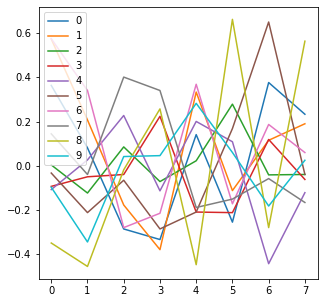

In [22]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

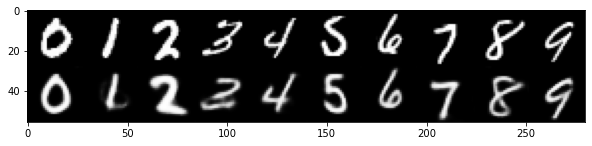

In [23]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [24]:
from XAE.sampler import gaus

exn = 5

In [25]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

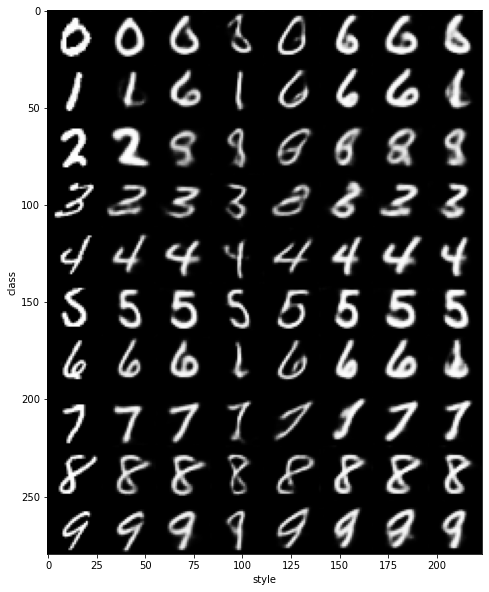

In [26]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [27]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

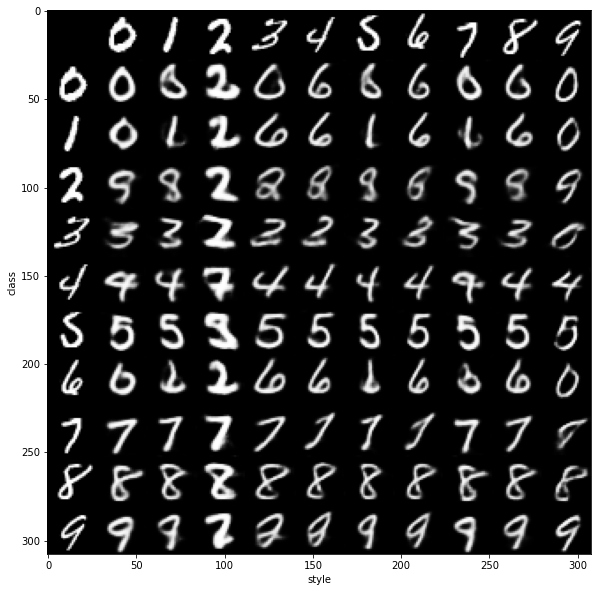

In [28]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()